# RGB-displayer for CRISM data

### Initial set up
Import required libraries, set up the directory to the data, grab the file names and load the CTX and CRISM images.

In [1]:
# Import all the stuff

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import pathlib
import csv
import math
import urllib
import xml.etree.ElementTree as ET
import spectral
import rasterio
import cv2
import plotly.express as px

from astropy.io import fits
from PIL.ExifTags import TAGS
from PIL import Image
from skimage import exposure


In [3]:
# Check the pwd and set the wd for the data

home = os.getcwd()
print('cwd:  ' + home)
#data_loc = home[:-7] + '\Data\Toro_data'
#print('Data: ' + data_loc)
#os.listdir(data_loc)

cwd:  C:\Users\21924709\Documents\PhD\Toro_21_03_24


In [13]:
# Grab all the file names for the data

ctx_fnames = glob.glob('./**/*.tiff', recursive=True)
crism_su_fnames = glob.glob('./**/*su*.img', recursive=True)

print("Number of CTX images:", len(ctx_fnames))
print("Number of CRISM images:", len(crism_su_fnames))

# Setup the bands for the CRISM data
bands = ['R770','RBR','BD530_2','SH600_2','SH770','BD640_2','BD860_2','BD920_2','RPEAK1','BDI1000VIS','R440','IRR1','BDI1000IR','OLINDEX3','R1330','BD1300','LCPINDEX2',
         'HCPINDEX2','VAR','ISLOPE1','BD1400','BD1435','BD1500_2','ICER1_2','BD1750_2','BD1900_2','BD1900R2','BDI2000','BD2100_2','BD2165','BD2190','MIN2200','BD2210_2',
         'D2200','BD2230','BD2250','MIN2250','BD2265','BD2290','D2300','BD2355','SINDEX2','ICER2_2','MIN2295_2480','MIN2345_2537','BD2500_2','BD3000','BD3100','BD3200',
         'BD3400_2','CINDEX2','BD2600','IRR2','IRR3','R530','R600','R1080','R1506','R2529','R3920']

print("Number of CRISM spectral summary products:", len(bands))

Number of CTX images: 27
Number of CRISM images: 9
Number of CRISM spectral summary products: 60


In [14]:
# Load the CTX images

Image.MAX_IMAGE_PIXELS = None # block the setting that prevents large files from opening

ctx_images = []

for i in np.arange(0, len(ctx_fnames)):
    ctx_images.append(Image.open(ctx_fnames[i]))

# Load the CRISM images

crism_su_images = []

for i in np.arange(0, len(crism_su_fnames)): # iterate through all images

    with rasterio.open(crism_su_fnames[i]) as src: # pretty sure this is a memory-efficient way of temporarily opening the data
        num_bands = src.count
        hyperspec_im = []                        # make an empty array that can hold each su product for that image
        
        for chn in range(1,60):                  # iterate throguh each channel, reading the image and saving it to full_im
            mono_image = src.read(chn)
            #plt.figure()
            #plt.imshow(channel, vmin=np.median(mono_image)-1*np.median(mono_image), vmax=np.median(mono_image)+1*np.median(mono_image))
            hyperspec_im.append(mono_image)
        
        crism_su_images.append(hyperspec_im)

### Generate images
Here, images are generated for the TRU (enhanced true colour) browse product, and three selected spectral summary products, which can (but do not have to) form a browse product. The list of SU and browse products can be found in Viviano-Beck et al., 2014 (doi: 10.1002/2014JE004627).

In [17]:
# Generate the three-channel images, for both the TRU image and desired science image

image_count = 3 # Select an image
R_vis, G_vis, B_vis = 'R600', 'R530', 'R440' # Grab three bands for TRU (true colour)
R, G, B = 'BD1900_2', 'BD1500_2', 'BD1435' # Select the three desired bands
browse = 'ICE'

# Get the three channel images (first for TRU, then for science)
red_image_vis   = crism_su_images[image_count][bands.index(R_vis)]
green_image_vis = crism_su_images[image_count][bands.index(G_vis)]
blue_image_vis  = crism_su_images[image_count][bands.index(B_vis)]

red_image   = crism_su_images[image_count][bands.index(R)]
green_image = crism_su_images[image_count][bands.index(G)]
blue_image  = crism_su_images[image_count][bands.index(B)]

# Set the NoData value to zero
red_image_vis[red_image_vis == 65535] = 0
green_image_vis[green_image_vis == 65535] = 0
blue_image_vis[blue_image_vis == 65535] = 0

red_image[red_image == 65535] = 0
green_image[green_image == 65535] = 0
blue_image[blue_image == 65535] = 0

# Normalize image
red_image_vis = red_image_vis/np.max(red_image_vis)
blue_image_vis = blue_image_vis/np.max(blue_image_vis)
green_image_vis = green_image_vis/np.max(green_image_vis)

red_image = red_image /np.max(red_image)
blue_image = blue_image/ np.max(blue_image)
green_image = green_image/ np.max(green_image)

# Apply histogram equalization to each band
red_image_vis_eq = exposure.equalize_hist(red_image_vis)
green_image_vis_eq = exposure.equalize_hist(green_image_vis)
blue_image_vis_eq = exposure.equalize_hist(blue_image_vis)

red_image_eq = exposure.equalize_hist(red_image)
green_image_eq = exposure.equalize_hist(green_image)
blue_image_eq = exposure.equalize_hist(blue_image)

# Stack the arrays to create the RGB composite
rgb_image_vis_eq = np.dstack((red_image_vis_eq, green_image_vis_eq, blue_image_vis_eq))
rgb_image_eq = np.dstack((red_image_eq, green_image_eq, blue_image_eq))


Enhanced true colour image and combination of BD1900_2 + BD1500_2 + BD1435, which form the ICE browse product.


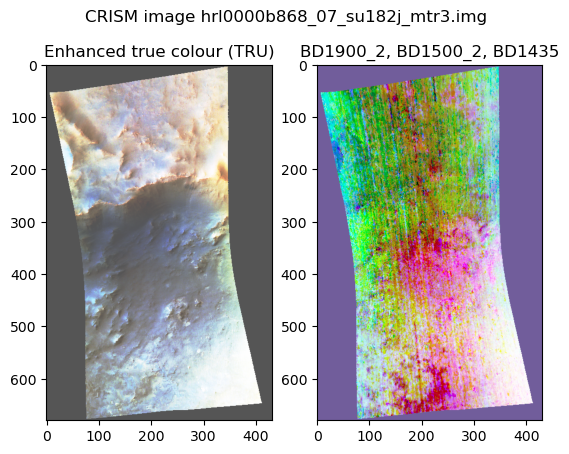

In [18]:
# Display the TRU and science RGB composite images
plt.figure()#figsize=(14,10))
plt.suptitle(f'CRISM image {crism_su_fnames[image_count][-30:]}')

plt.subplot(121)
plt.imshow(rgb_image_vis_eq)
plt.title('Enhanced true colour (TRU)')

plt.subplot(122)
plt.imshow(rgb_image_eq)
plt.title(f'{R}, {G}, {B}')

print(f'Enhanced true colour image and combination of {R} + {G} + {B}, which form the {browse} browse product.')

### Add spatial information
This imports the spatial data.

In [ ]:
#If you need to expore the image with spatial information, uncomment this box
outfile = 'D:/PHYND/PHYND_Output/binary_' + fileid +'_binarycombined_test.tiff'

 # Open the source raster file
with rasterio.open(file) as src2:
 
 # Copy the profile of the source raster file
    profile = src2.profile

 # Read only a single band of the raster file
    first_band = src2.read(1)

 # Update the profile to reflect the number of bands
    profile.update(count=1)
    
# Now you can use this profile to create a new raster file with the same profile
    with rasterio.open(outfile, 'w', **profile) as dst:
    # Write data to the new file
        dst.write(grey_combined,1)